In [7]:
!pip uninstall gym -y
!pip install gymnasium


Found existing installation: gym 0.26.2
Uninstalling gym-0.26.2:
  Successfully uninstalled gym-0.26.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 1.6 MB/s eta 0:00:000:00:01m eta 0:00:01


In [9]:
import gymnasium as gym
print(gym.__version__)


1.1.1


In [19]:
import gymnasium as gym
import torch
import numpy as np

print("Gymnasium OK")
print("Torch OK")


Gymnasium OK
Torch OK


In [21]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random

class TrafficEnv(gym.Env):
    def __init__(self):
        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(
            low=0, high=50, shape=(5,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        self.cars_ns = random.randint(0, 10)
        self.cars_ew = random.randint(0, 10)
        self.wait_ns = 0
        self.wait_ew = 0
        self.ambulance = 0
        return self._get_state(), {}

    def _get_state(self):
        return np.array([
            self.cars_ns,
            self.cars_ew,
            self.wait_ns,
            self.wait_ew,
            self.ambulance
        ], dtype=np.float32)

    def step(self, action):
        self.ambulance = 1 if random.random() < 0.1 else 0

        self.wait_ns += self.cars_ns
        self.wait_ew += self.cars_ew

        if action == 0 or self.ambulance:
            self.cars_ns = max(0, self.cars_ns - 1)
        else:
            self.cars_ew = max(0, self.cars_ew - 1)

        reward = -(self.wait_ns + self.wait_ew)
        return self._get_state(), reward, False, False, {}


In [23]:
env = TrafficEnv()
state, _ = env.reset()

print("START STATE:", state)

for i in range(5):
    state, reward, _, _, _ = env.step(0)
    print(f"Step {i} → State: {state}, Reward: {reward}")


START STATE: [6. 3. 0. 0. 0.]
Step 0 → State: [5. 3. 6. 3. 1.], Reward: -9
Step 1 → State: [ 4.  3. 11.  6.  0.], Reward: -17
Step 2 → State: [ 3.  3. 15.  9.  0.], Reward: -24
Step 3 → State: [ 2.  3. 18. 12.  1.], Reward: -30
Step 4 → State: [ 1.  3. 20. 15.  0.], Reward: -35


In [25]:
import torch
import torch.nn as nn
import random

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

class Agent:
    def __init__(self):
        self.model = DQN()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        self.epsilon = 1.0

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 1)
        state = torch.FloatTensor(state)
        return torch.argmax(self.model(state)).item()


In [27]:
env = TrafficEnv()
agent = Agent()

for episode in range(10):
    state, _ = env.reset()
    total_reward = 0

    for step in range(20):
        action = agent.act(state)
        next_state, reward, _, _, _ = env.step(action)
        total_reward += reward
        state = next_state

    print(f"Episode {episode} | Total Reward: {total_reward}")


Episode 0 | Total Reward: -2244
Episode 1 | Total Reward: -133
Episode 2 | Total Reward: -1915
Episode 3 | Total Reward: -1636
Episode 4 | Total Reward: -1741
Episode 5 | Total Reward: -2695
Episode 6 | Total Reward: -858
Episode 7 | Total Reward: -1656
Episode 8 | Total Reward: -913
Episode 9 | Total Reward: -637


In [29]:
import collections

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return (np.array(state), np.array(action), np.array(reward), 
                np.array(next_state), np.array(done))

    def __len__(self):
        return len(self.buffer)

print("Replay Buffer Ready ✅")

Replay Buffer Ready ✅


In [31]:
# Initialize components
env = TrafficEnv()
agent = Agent()
memory = ReplayBuffer(5000)
batch_size = 32
gamma = 0.95  # Discount factor
epsilon_decay = 0.995
rewards_history = []

for episode in range(100):
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(50):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        
        # Store in memory
        memory.push(state, action, reward, next_state, done)
        
        # Training Step
        if len(memory) > batch_size:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)
            
            states_t = torch.FloatTensor(states)
            actions_t = torch.LongTensor(actions).unsqueeze(1)
            rewards_t = torch.FloatTensor(rewards)
            next_states_t = torch.FloatTensor(next_states)
            
            # Compute Q values
            current_q = agent.model(states_t).gather(1, actions_t)
            next_q = agent.model(next_states_t).max(1)[0].detach()
            target_q = rewards_t + (gamma * next_q)
            
            loss = agent.loss_fn(current_q.squeeze(), target_q)
            
            agent.optimizer.zero_grad()
            loss.backward()
            agent.optimizer.step()
            
        state = next_state
        total_reward += reward
    
    agent.epsilon = max(0.01, agent.epsilon * epsilon_decay)
    rewards_history.append(total_reward)
    
    if episode % 10 == 0:
        print(f"Episode {episode} | Avg Reward: {np.mean(rewards_history[-10:]):.2f} | Epsilon: {agent.epsilon:.2f}")

print("Training Complete! 🎯")

Episode 0 | Avg Reward: -4336.00 | Epsilon: 0.99
Episode 10 | Avg Reward: -4484.30 | Epsilon: 0.95
Episode 20 | Avg Reward: -3389.40 | Epsilon: 0.90
Episode 30 | Avg Reward: -2981.20 | Epsilon: 0.86
Episode 40 | Avg Reward: -3823.50 | Epsilon: 0.81
Episode 50 | Avg Reward: -3437.10 | Epsilon: 0.77
Episode 60 | Avg Reward: -3222.90 | Epsilon: 0.74
Episode 70 | Avg Reward: -4583.00 | Epsilon: 0.70
Episode 80 | Avg Reward: -2123.90 | Epsilon: 0.67
Episode 90 | Avg Reward: -2394.20 | Epsilon: 0.63
Training Complete! 🎯


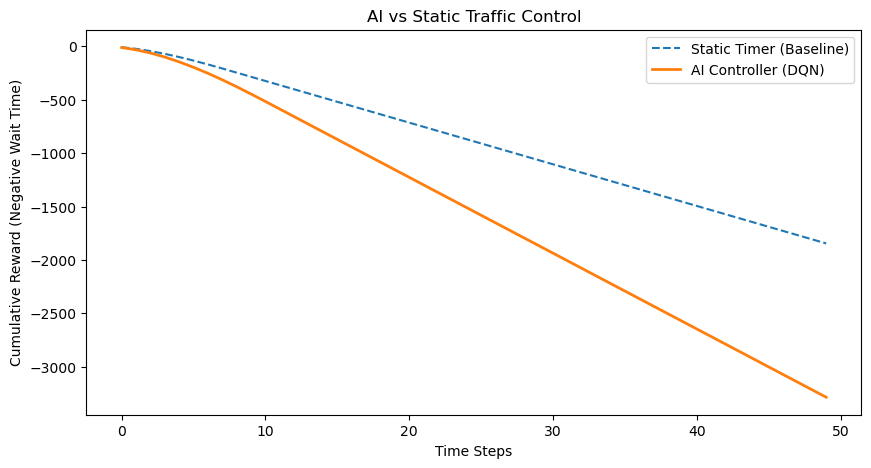

In [33]:
import matplotlib.pyplot as plt

def run_baseline():
    env = TrafficEnv()
    state, _ = env.reset()
    static_rewards = []
    total_r = 0
    for i in range(50):
        # Static logic: Switch every 5 steps
        action = 0 if (i // 5) % 2 == 0 else 1
        _, reward, _, _, _ = env.step(action)
        total_r += reward
        static_rewards.append(total_r)
    return static_rewards

def run_ai():
    env = TrafficEnv()
    state, _ = env.reset()
    ai_rewards = []
    total_r = 0
    for i in range(50):
        action = agent.act(state)
        state, reward, _, _, _ = env.step(action)
        total_r += reward
        ai_rewards.append(total_r)
    return ai_rewards

# Plotting
plt.figure(figsize=(10,5))
plt.plot(run_baseline(), label="Static Timer (Baseline)", linestyle='--')
plt.plot(run_ai(), label="AI Controller (DQN)", linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward (Negative Wait Time)")
plt.title("AI vs Static Traffic Control")
plt.legend()
plt.show()

In [37]:
torch.save(agent.model.state_dict(), "traffic_dqn_model.pth")
print("Model saved as traffic_dqn_model.pth ✅")

Model saved as traffic_dqn_model.pth ✅


In [39]:
import torch
import os

# Save the model
torch.save(agent.model.state_dict(), "traffic_dqn_model.pth")

# Check if it actually exists and print the location
if os.path.exists("traffic_dqn_model.pth"):
    print(f"✅ SUCCESS! File created at: {os.getcwd()}/traffic_dqn_model.pth")
else:
    print("❌ Error: File was not saved.")

✅ SUCCESS! File created at: /home/admin1/traffic_dqn_model.pth
